In [1]:
import  pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold
from sklearn.manifold import TSNE

import matplotlib
%matplotlib inline
sns.set(font_scale=0.5)
plt.rcParams['figure.dpi'] = 150
pd.set_option("display.max_columns", None)

# Get data

In [2]:
df_data = pd.read_excel('St. Olavs ED 2010-2022.xlsx',sheet_name='Data')

FileNotFoundError: [Errno 2] No such file or directory: 'St. Olavs ED 2010-2022.xlsx'

In [3]:
df_var = pd.read_excel('St. Olavs ED 2010-2022.xlsx',sheet_name='Variables')

In [39]:
df_var

,Variable,Example,Source/dataset,Description,Type
0,akdb_InnAkutt,2010-01-02 18:14:00,Akuttdatabasen,Date and time for ED entry,Continues
1,akdb_UtAkutt,2010-01-03 07:03:30,Akuttdatabasen,Date and time for ED discharge,Continues
2,akdb_AkuttGruppeBeskrivelse,ORT,Akuttdatabasen,Emergency group,Categorical
3,akdb_HastegradBeskriveles,Grønn,Akuttdatabasen,"Triage code in the ED. Blå = blue, grønn = gre...",Categorical
4,akdb_UtskrevetTilBeskrivelse,ORS,Akuttdatabasen,Place of discharge,Categorical
5,akdb_ESS,t36.3,Akuttdatabasen,ESS code,Categorical
6,pasient_Fødselsdato,1921-10-26 00:00:00,Akuttdatabasen,Patient birth-date,Continues
7,pasiet_Dødsdato,2012-04-03 00:00:00,Akuttdatabasen,Patient death-date,Continues
8,pasient_kjønn,Kvinne,Akuttdatabasen,"Sex. Kvinne = Female, mann = male",Binary
9,nimes_FagområdeBeskrivelse,050 Ortopedisk kir (inkl revmakir),Nimes,NaN,Categorical


In [5]:
df_data.head()

,akdb_InnAkutt,akdb_UtAkutt,akdb_AkuttGruppeBeskrivelse,akdb_HastegradBeskrivelse,akdb_UtskrevetTilBeskrivelse,akdb_ESS,pasient_Fødselsdato,pasient_Dødsdato,pasient_kjønn,nimes_FagområdeBeskrivelse,nimes_IK4489Kode,nimes_IK4489Beskrivelse,nimes_PDXKoder,nimes_SDXKoder,nimes_PDXKoderBeskrivelse,nimes_Uttilstand
0,2010-01-01 01:15:00,2010-01-01 02:50:00,MED,Gul,MSLAG,T35.3,06.12.1932,NaN,Kvinne,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-01 05:11:00,2010-01-01 05:35:00,MED,Rød,INTENSIV,t49.1,30.07.1983,NaN,Kvinne,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-01 06:25:00,2010-01-01 08:33:00,KIR,Grønn,KGAS2,31.4,08.09.1919,29.08.2010,Mann,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-01 08:45:00,2010-01-01 09:14:00,MED,Oransje,HMB8,45.2,17.06.1948,NaN,Mann,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-01 09:22:00,2010-01-01 10:45:00,MED,Gul,HMB8,6.3,04.05.1954,NaN,Mann,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_data.akdb_InnAkutt.dt.year.min(),df_data.akdb_InnAkutt.dt.year.max(),len(df_data)

(2010, 2022, 304997)

In [65]:
df_data.akdb_UtskrevetTilBeskrivelse.value_counts()

MOTP      50359
MOTOBS    42894
NEVS      14918
MSLAG     14093
HMS2      12219
          ...  
MOTPAG        4
MOTPAE        2
OHS           2
MOTPAK        2
MOTPAU        1
Name: akdb_UtskrevetTilBeskrivelse, Length: 80, dtype: int64

In [64]:
df_data.nimes_FagområdeBeskrivelse.value_counts()

150 Hjertesykdommer                     31198
110 Generell indremedisin               28222
030 Gastroenterologisk kir              19406
250 Nevrologi                           18368
*Ukjent                                 17811
                                        ...  
823 Medisinsk mikrobiologi                  2
860 Patologi                                1
852 Radiologi                               1
232 Habilitering                            1
830 Immunologi og transfusjonsmedisi        1
Name: nimes_FagområdeBeskrivelse, Length: 69, dtype: int64

### Some distributions

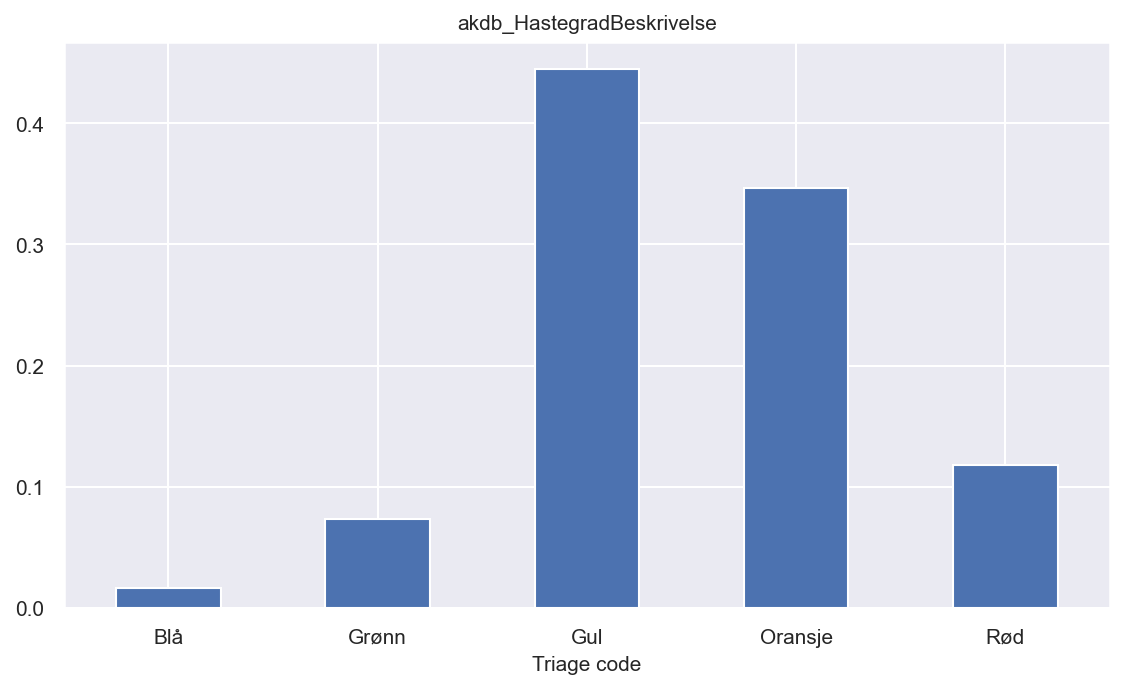

In [41]:
#df_data['Triage'] = pd.Categorical(df_data['akdb_HastegradBeskrivelse'], ["Blå", "Grønn", "Dec"])
ax = df_data.akdb_HastegradBeskrivelse.value_counts(normalize=True).sort_index().plot(kind='bar',figsize=(9,5),rot=0)
ax.set_title('akdb_HastegradBeskrivelse',fontsize = 10)
ax.set_xlabel('Triage code',fontsize = 10)
ax.set_ylabel('',fontsize = 10)
ax.tick_params(axis='both', labelsize=10)

Text(0.5, 1.0, 'akdb_UtskrevetTilBeskrivelse')

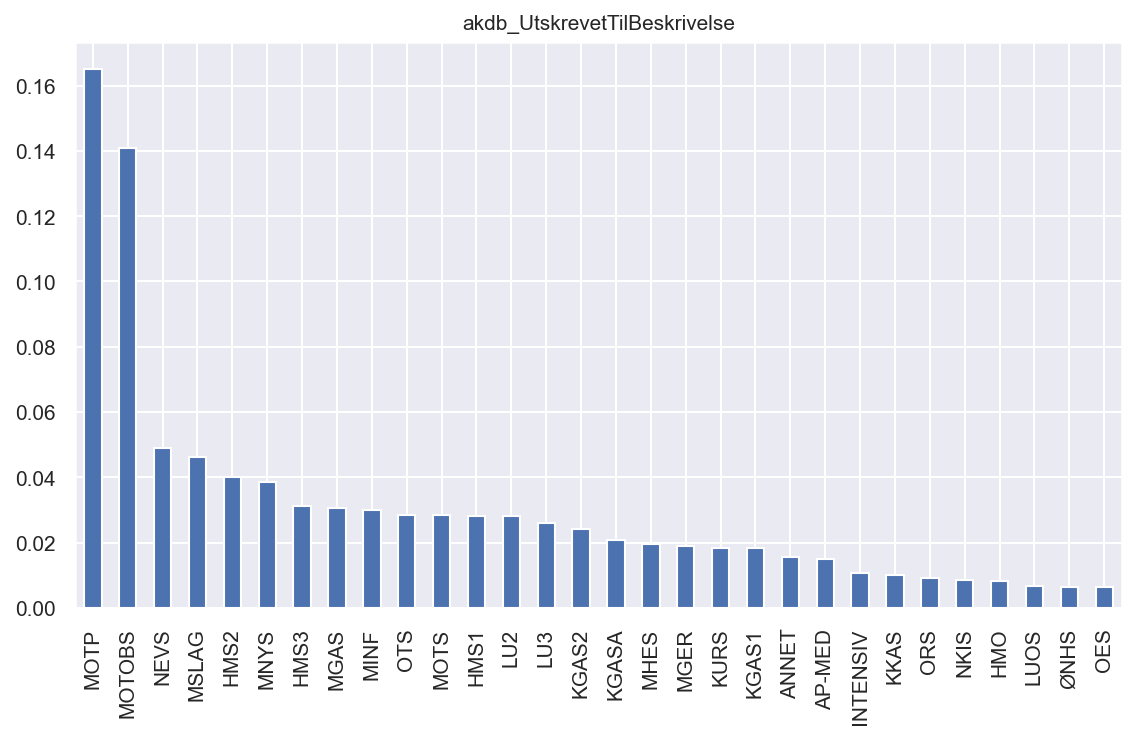

In [42]:
ax = df_data.akdb_UtskrevetTilBeskrivelse.value_counts(normalize=True).head(30).plot(kind='bar',figsize=(9,5))
ax.tick_params(axis='both', labelsize=10)
ax.set_xlabel('',fontsize = 10)
ax.set_ylabel('',fontsize = 10)
ax.set_title('akdb_UtskrevetTilBeskrivelse',fontsize = 10)

### Feature engineering

In [8]:
df_clean = df_data.copy()

#Some have missing birthdate
df_clean = df_clean.dropna(subset='pasient_Fødselsdato')

#Remove EDLOS large than 24 hours, and negative values
df_clean['EDLOS'] = (df_clean.akdb_UtAkutt - df_clean.akdb_InnAkutt).dt.total_seconds()/60
df_clean = df_clean[(df_clean.EDLOS < 24*60) & (df_clean.EDLOS>0)]

#Calculate Age
df_clean['pasient_Fødselsdato'] = pd.to_datetime(df_clean['pasient_Fødselsdato'],format='%d.%m.%Y')
df_clean['pasient_Dødsdato'] = pd.to_datetime(df_clean['pasient_Dødsdato'],format='%d.%m.%Y')
df_clean['Alder'] = ((df_clean.akdb_InnAkutt - df_clean.pasient_Fødselsdato).dt.days/365).apply(lambda x: int(round(x)))

#Define 24 hours mortality and Discharged to ICU or surgery
df_clean['24hmrt'] = np.where((df_clean.pasient_Dødsdato - df_clean.akdb_InnAkutt).dt.days <= 1,1,0)
df_clean['DischICU'] = np.where(df_clean.akdb_UtskrevetTilBeskrivelse.isin(['INTENSIV','OPERASJON']),1,0)

#Time variables
df_clean['Time_in_Hour'] = df_clean.akdb_InnAkutt.dt.hour
df_clean ['Ukedag'] = df_clean.akdb_InnAkutt.dt.dayofweek.map({0:'Mandag',1:'Tirsdag',2:'Onsdag',3:'Torsdag',4:'Fredag',5:'Lørdag',6:'Søndag'})

#Combine variable to be used as a target
df_clean['Mrt_AND_OR_ICU'] = np.where(df_clean['24hmrt'] + df_clean['DischICU'] > 0,1,0)

In [55]:
# ax = df_clean[(df_clean.akdb_HastegradBeskrivelse.isin(['Blå','Grønn','Gul'])) & (df_clean.Mrt_AND_OR_ICU==1)].EDLOS.hist(density=True,alpha=0.5,range=[0,600],bins=100)
# df_clean[~(df_clean.akdb_HastegradBeskrivelse.isin(['Blå','Grønn','Gul'])) & (df_clean.Mrt_AND_OR_ICU==1)].EDLOS.hist(ax=ax,density=True,alpha=0.5,range=[0,600],bins=100)

In [10]:
# ax = df_clean[(df_clean.akdb_HastegradBeskrivelse.isin(['Blå','Grønn','Gul'])) & (df_clean.Mrt_AND_OR_ICU==1)].Alder.hist(density=True,alpha=0.5,range=[0,100],bins=50)
# df_clean[~(df_clean.akdb_HastegradBeskrivelse.isin(['Blå','Grønn','Gul'])) & (df_clean.Mrt_AND_OR_ICU==1)].Alder.hist(ax=ax,density=True,alpha=0.5,range=[0,100],bins=50)

In [11]:
df_clean.akdb_HastegradBeskrivelse.value_counts(normalize=True)

Gul        0.446285
Oransje    0.348991
Rød        0.116520
Grønn      0.073073
Blå        0.015131
Name: akdb_HastegradBeskrivelse, dtype: float64

# Modeling

**Classification model: Which patients are severe (dead within 24 hours or ICU/surgery) and get a triage: Blue, green or yellow**

In [57]:
features = ['akdb_AkuttGruppeBeskrivelse','Time_in_Hour','pasient_kjønn','Ukedag','Alder','nimes_FagområdeBeskrivelse']

X = df_clean.loc[df_clean.Mrt_AND_OR_ICU==1,features]
y = pd.Series(np.where(df_clean.loc[df_clean.Mrt_AND_OR_ICU==1,'akdb_HastegradBeskrivelse'].isin(['Blå','Grønn','Gul']),1,0))
y.value_counts(normalize=False)

0    5832
1     513
dtype: int64

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6345 entries, 1 to 304947
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   akdb_AkuttGruppeBeskrivelse  6345 non-null   object
 1   Time_in_Hour                 6345 non-null   int64 
 2   pasient_kjønn                6345 non-null   object
 3   Ukedag                       6345 non-null   object
 4   Alder                        6345 non-null   int64 
 5   nimes_FagområdeBeskrivelse   5299 non-null   object
dtypes: int64(2), object(4)
memory usage: 347.0+ KB


In [14]:
def cv_roc(X,y,estimator,cv,groups=None):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    
    for train, test in cv.split(X,y,groups):
        probas_ = estimator.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])

        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.1f)' % (i, roc_auc*100))

        i += 1
    plt.plot([0, 1], [0, 1], 'r--')

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)*3
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.1f $\pm$ %0.1f)' % (mean_auc*100, std_auc*100),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)*3
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 3 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
num_pipe = make_pipeline(SimpleImputer(strategy="mean"))#,StandardScaler())
cat_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),# fill_value="missing"),
   # OneHotEncoder(handle_unknown='ignore',sparse=False)
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
)

preprocessor = make_column_transformer(
    (num_pipe, selector(dtype_include=['int64','float64'])),
    (cat_pipe, selector(dtype_include=['object'])),
    n_jobs=2,
)

In [16]:


rf_clf = make_pipeline(
    preprocessor,
  # RandomUnderSampler(random_state=42),
    # xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss')
    RandomForestClassifier(random_state=42,class_weight="balanced")
   # BalancedRandomForestClassifier()
)


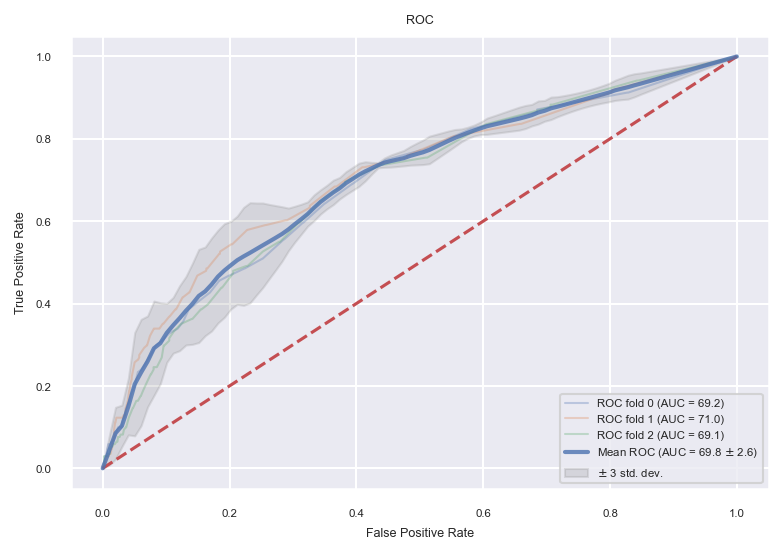

In [17]:
cv=StratifiedKFold(n_splits=3,shuffle=True)
cv_roc(X,y,rf_clf,cv)

In [18]:
import shap
shap.initjs()

In [19]:

X_t = preprocessor.fit_transform(X)

cols = preprocessor.transformers_[0][2] + preprocessor.transformers_[1][2]

rf = RandomForestClassifier(random_state=42,class_weight="balanced").fit(X_t,y)

explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_t)
exp = shap.Explanation(shap_values.values[:,:,1], 
                  shap_values.base_values[:,1], 
                  data=X_t, 
                  feature_names=cols)

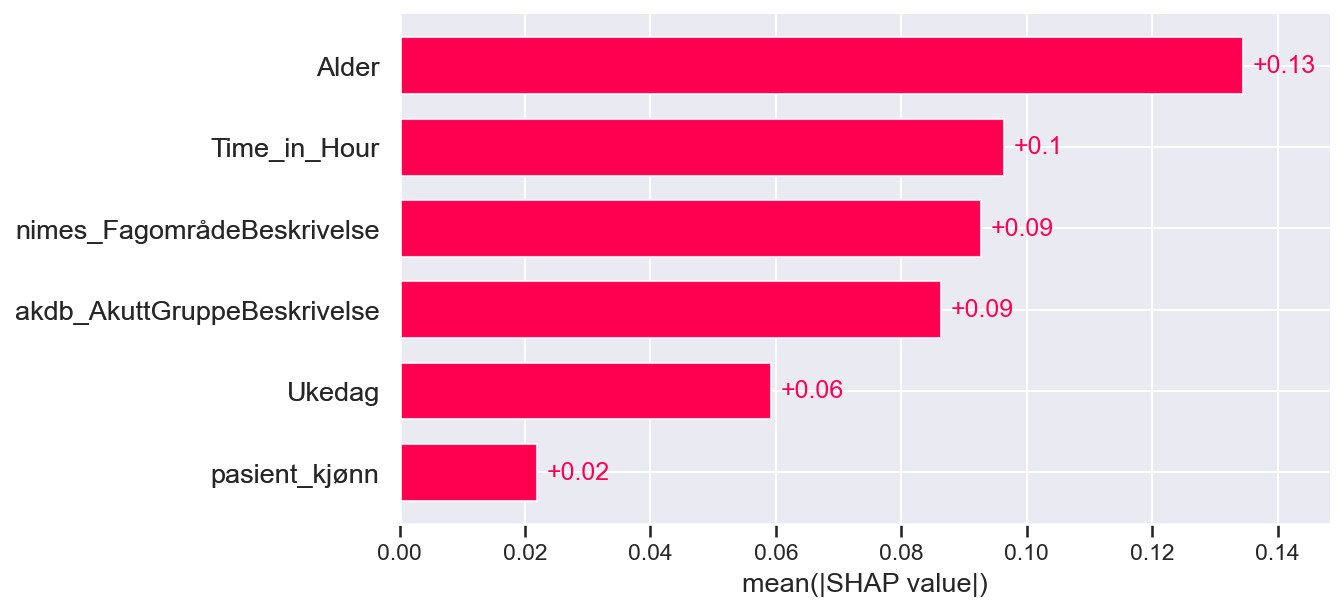

In [20]:
shap.plots.bar(exp,max_display=20)

In [21]:
# shap.summary_plot(exp[:,['Alder']])

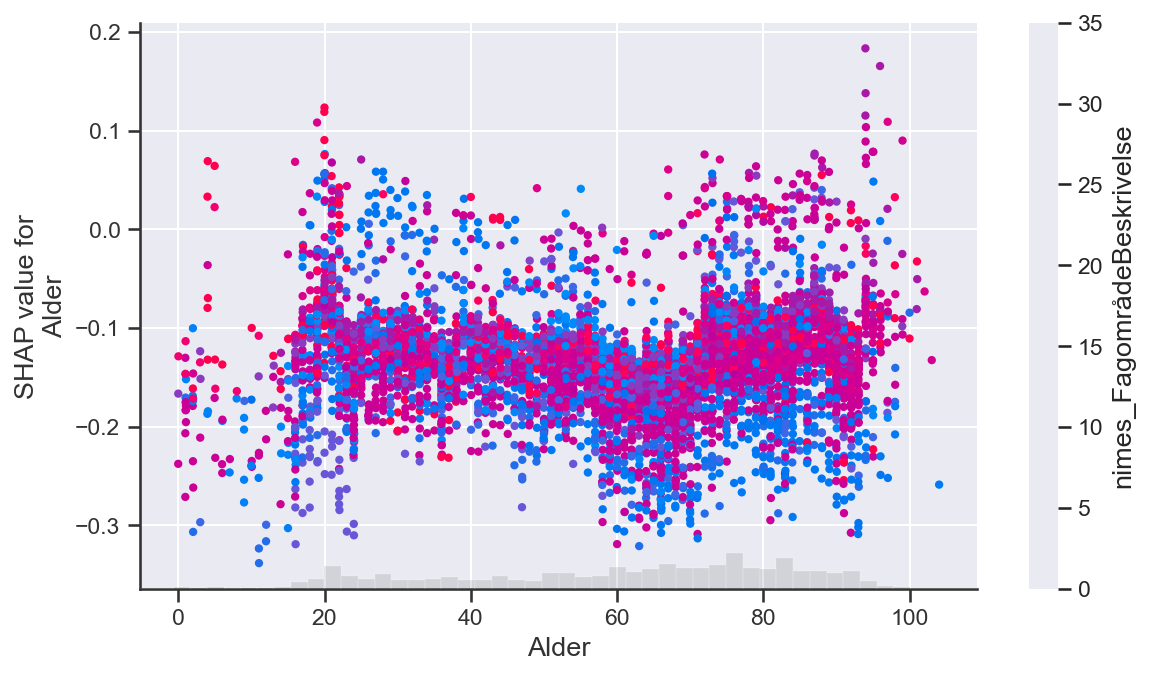

In [49]:

fig, ax = plt.subplots(figsize=(9,5))
num_variable = 'Alder'

shap.plots.scatter(exp[:,num_variable],ax=ax,xmax=None, color=exp)#[:,'Alder'])


In [23]:
features

['akdb_AkuttGruppeBeskrivelse',
 'Time_in_Hour',
 'pasient_kjønn',
 'Ukedag',
 'Alder',
 'nimes_FagområdeBeskrivelse']

FixedFormatter should only be used together with FixedLocator


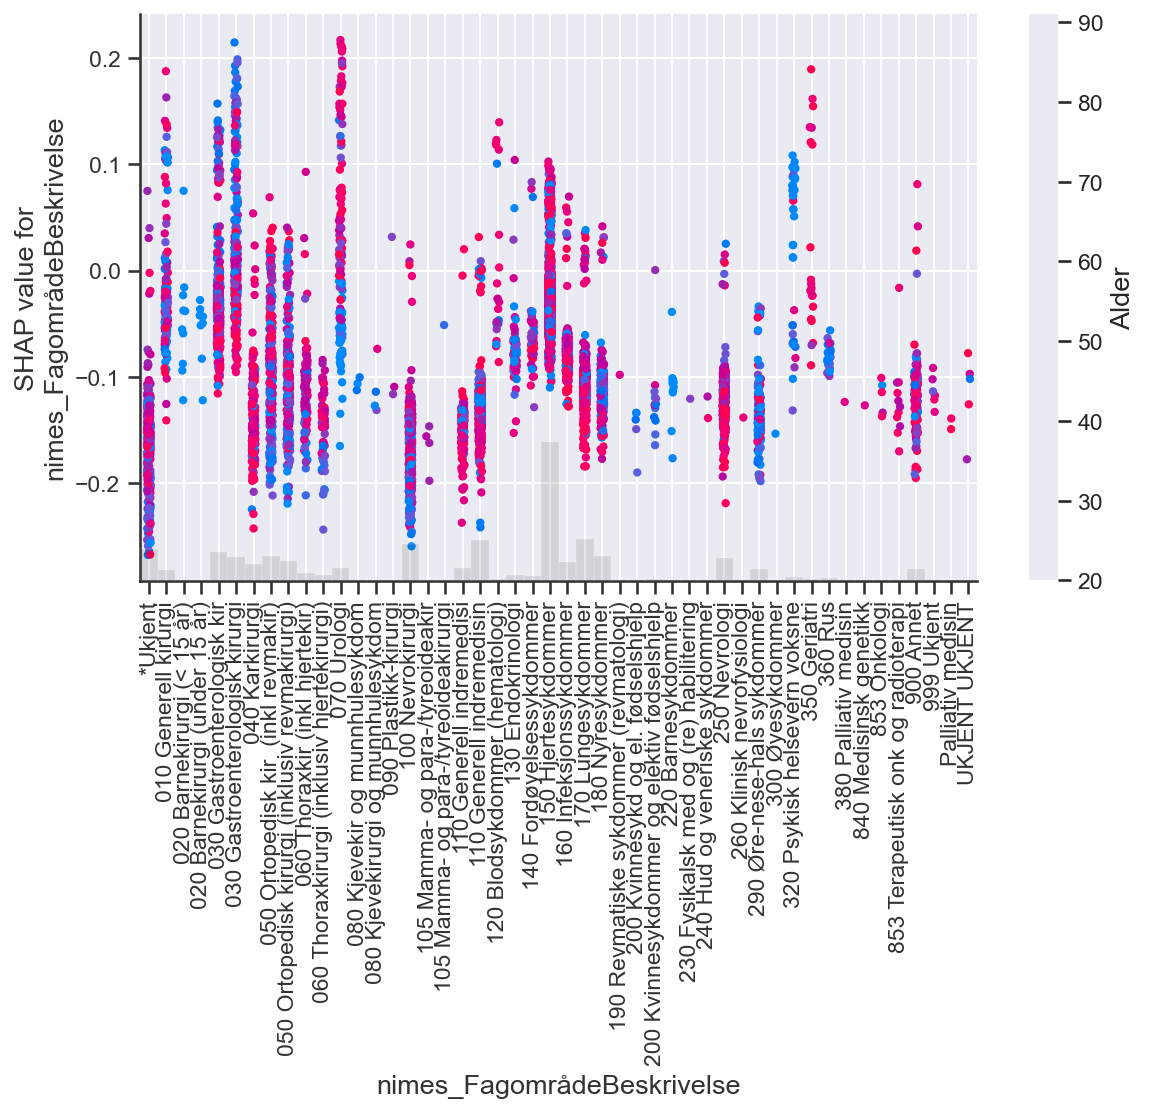

In [62]:
fig, ax = plt.subplots(figsize=(9,5))
cat_variable = 'nimes_FagområdeBeskrivelse'
t = preprocessor.transformers_[1][1][1]

ax.set_xticklabels(t.categories_[preprocessor.transformers_[1][2].index(cat_variable)],rotation=90)
ax.set_xticks(np.arange(0,len(t.categories_[preprocessor.transformers_[1][2].index(cat_variable)])))
shap.plots.scatter(exp[:,cat_variable],ax=ax, color=exp[:,'Alder'])



In [54]:
t.categories_[preprocessor.transformers_[1][2].index('nimes_FagområdeBeskrivelse')][5]

'030 Gastroenterologisk kirurgi'